# Week 3 Segmenting and Clustering Neighborhood in Toronto

## Part 1

### Importing the libraries

In [1]:
import requests
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd

print("Libraries imported.")

Libraries imported.


### Requesting information in the URL

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urllib.request.urlopen(url)  

### Parsing into the BeautifulSoup format

In [3]:
soup = BeautifulSoup(page, "lxml")

### Creating the DataFrame

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

### Visualizing the Dataframe

In [5]:
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Dataframe Shape

In [6]:
df.shape

(103, 3)

## Part 2

### Importing libraries

In [7]:
from geopy.geocoders import Nominatim
import folium

### Reading CSV

In [8]:
df_coor = pd.read_csv('/Users/phsol/Documents/Cursos/SQL IBM/10/Geospatial_Coordinates.csv')
df_coor.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging dataframes

In [9]:
df_neighborhood = pd.merge(df, df_coor, on="Postal Code", how="left")
df_neighborhood.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_neighborhood['Borough'].unique()),
        df_neighborhood.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


## Part 3

In [11]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### creating map and adding markers of all neighborhoods

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Borough'], df_neighborhood['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [13]:
# @hidden cell

CLIENT_ID = '3U0XPBK5J1TMB1OWNLC3CTNWGU1NV0ZSA031WOW0032XDCZC' 
CLIENT_SECRET = 'D4CU3J0YTF4BPOKHNHNTCM2MBQVQSTYH3UMISOT3FO1V4SI5' 
VERSION = '20210520' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius=500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3U0XPBK5J1TMB1OWNLC3CTNWGU1NV0ZSA031WOW0032XDCZC
CLIENT_SECRET:D4CU3J0YTF4BPOKHNHNTCM2MBQVQSTYH3UMISOT3FO1V4SI5


In [14]:
neighborhood_latitude = df_neighborhood.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_neighborhood.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_neighborhood.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [15]:
def get_categories_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500): # radius is 500m
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
Toronto_venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['Latitude'],
                                   longitudes=df_neighborhood['Longitude'])

In [18]:
Toronto_venues.shape

(2119, 7)

In [19]:
Toronto_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [20]:
print('{} uniques categories'.format(Toronto_venues['Venue Category'].nunique()))

271 uniques categories


## CLUSTERING

### Choosing a good place to open a new Bakery

In [21]:
df_bakery = Toronto_venues[Toronto_venues['Venue Category'] == 'Bakery'].reset_index(drop=True)
print(df_bakery.shape)
df_bakery.head()

(43, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Brick Street Bakery,43.650574,-79.359539,Bakery
2,"Regent Park, Harbourfront",43.654260,-79.360636,The Sweet Escape Patisserie,43.650632,-79.358709,Bakery
3,"Garden District, Ryerson",43.657162,-79.378937,Danish Pastry House,43.654574,-79.380740,Bakery
4,Glencairn,43.709577,-79.445073,"R Bakery - Delicious Cakes, Breads",43.707420,-79.443126,Bakery


In [22]:
Toronto_venues.Neighborhood.value_counts()

First Canadian Place, Underground city                                    100
Harbourfront East, Union Station, Toronto Islands                         100
Enclave of M5E                                                            100
Commerce Court, Victoria Hotel                                            100
Toronto Dominion Centre, Design Exchange                                  100
                                                                         ... 
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale      1
Humberlea, Emery                                                            1
Malvern, Rouge                                                              1
The Kingsway, Montgomery Road, Old Mill North                               1
York Mills, Silver Hills                                                    1
Name: Neighborhood, Length: 101, dtype: int64

In [23]:
most_venues=Toronto_venues.Neighborhood.value_counts().to_frame()
optimal_venues = most_venues[(most_venues.Neighborhood < 65) & (most_venues.Neighborhood >= 40) ]
optimal_neigs = optimal_venues.index.tolist()

df_40_65 = pd.DataFrame()
for neig in optimal_neigs:
    df_40_65 = df_40_65.append(Toronto_venues[Toronto_venues['Neighborhood'] == neig], ignore_index=True)

In [24]:
most_venues=Toronto_venues.Neighborhood.value_counts().to_frame()
optimal_venues = most_venues[(most_venues.Neighborhood < 65) & (most_venues.Neighborhood >= 40) ]
optimal_neigs = optimal_venues.index.tolist()
optimal_neigs

['Central Bay Street',
 'Kensington Market, Chinatown, Grange Park',
 'Berczy Park',
 'St. James Town, Cabbagetown',
 'Little Portugal, Trinity',
 'Regent Park, Harbourfront',
 'The Danforth West, Riverdale']

In [25]:
df_40_65 = pd.DataFrame()
for neig in optimal_neigs:
    df_40_65 = df_40_65.append(Toronto_venues[Toronto_venues['Neighborhood'] == neig], ignore_index=True)
print(df_40_65.shape)
df_40_65.head()

(361, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Bay Street,43.657952,-79.387383,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
1,Central Bay Street,43.657952,-79.387383,Somethin' 2 Talk About,43.658395,-79.385338,Middle Eastern Restaurant
2,Central Bay Street,43.657952,-79.387383,Hailed Coffee,43.658833,-79.383684,Coffee Shop
3,Central Bay Street,43.657952,-79.387383,Tim Hortons,43.658570,-79.385123,Coffee Shop
4,Central Bay Street,43.657952,-79.387383,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop


In [26]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map

# add populer spots as blue circle markers   
for lat, lng, label in zip(df_40_65['Venue Latitude'], df_40_65['Venue Longitude'], df_40_65['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        fill=True,
        color='blue',
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(venues_map) 
# add the Bakeries as red circle markers
for lat, lng, label in zip(df_bakery['Venue Latitude'], df_bakery['Venue Longitude'], df_bakery['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.4,
        parse_html=False).add_to(venues_map)
    

# display map
venues_map

In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_40_65[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_40_65['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bagel Shop,Bakery,Bank,...,Thai Restaurant,Theater,Tibetan Restaurant,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
toronto_onehot.shape

(361, 137)

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bagel Shop,Bakery,Bank,...,Thai Restaurant,Theater,Tibetan Restaurant,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.00000,0.000000,0.016393,0.000000,0.000000,0.000000,0.016393,0.049180,0.000000,...,0.016393,0.000000,0.00000,0.00000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000
1,Central Bay Street,0.00000,0.000000,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.015873,...,0.031746,0.000000,0.00000,0.00000,0.015873,0.000000,0.015873,0.000000,0.000000,0.015873
2,"Kensington Market, Chinatown, Grange Park",0.00000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.016129,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.048387,0.048387,0.016129,0.000000,0.016129,0.000000
3,"Little Portugal, Trinity",0.00000,0.000000,0.022727,0.000000,0.000000,0.045455,0.000000,0.022727,0.000000,...,0.000000,0.022727,0.00000,0.00000,0.045455,0.045455,0.022727,0.000000,0.000000,0.022727
4,"Regent Park, Harbourfront",0.00000,0.022727,0.022727,0.000000,0.000000,0.022727,0.000000,0.068182,0.022727,...,0.000000,0.045455,0.00000,0.00000,0.000000,0.000000,0.000000,0.022727,0.000000,0.022727
5,"St. James Town, Cabbagetown",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065217,0.021739,...,0.021739,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"The Danforth West, Riverdale",0.02439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,...,0.000000,0.000000,0.02439,0.02439,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390


In [30]:
toronto_grouped.shape

(7, 137)

In [31]:
import numpy as np

num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue_category ','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
  venue_category   freq
0     Coffee Shop  0.10
1    Cocktail Bar  0.07
2          Bakery  0.05
3        Beer Bar  0.03
4      Restaurant  0.03


----Central Bay Street----
      venue_category   freq
0         Coffee Shop  0.17
1  Italian Restaurant  0.05
2      Sandwich Place  0.05
3                Café  0.05
4     Thai Restaurant  0.03


----Kensington Market, Chinatown, Grange Park----
                 venue_category   freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.05
3          Vietnamese Restaurant  0.05
4                   Burger Joint  0.03


----Little Portugal, Trinity----
    venue_category   freq
0               Bar  0.09
1       Coffee Shop  0.07
2       Men's Store  0.05
3        Restaurant  0.05
4  Asian Restaurant  0.05


----Regent Park, Harbourfront----
  venue_category   freq
0     Coffee Shop  0.16
1            Park  0.07
2          Bakery  0.07
3            Café  0.05
4     

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Seafood Restaurant,Beer Bar,Cheese Shop,Restaurant,Pharmacy,Breakfast Spot
1,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Burger Joint
2,"Kensington Market, Chinatown, Grange Park",Café,Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gaming Cafe,Grocery Store,Park,Bar,Farmers Market,Burger Joint
3,"Little Portugal, Trinity",Bar,Coffee Shop,Restaurant,Café,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Men's Store,Italian Restaurant,Japanese Restaurant
4,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Theater,Pub,Café,Breakfast Spot,Electronics Store,Event Space,Distribution Center
5,"St. James Town, Cabbagetown",Bakery,Coffee Shop,Restaurant,Pizza Place,Park,Café,Chinese Restaurant,Pub,Italian Restaurant,Indian Restaurant
6,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Yoga Studio,Pizza Place,Lounge,Liquor Store,Juice Bar


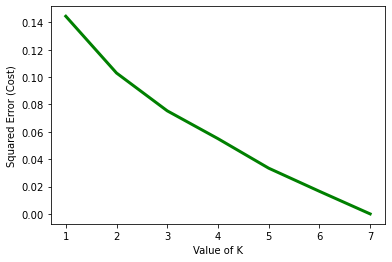

In [34]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

cost =[] 
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

for i in range(1, 8): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(toronto_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      

# plot the cost against K values   
plt.plot(range(1, 8), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

In [35]:
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1])

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neighborhood

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print(toronto_merged.shape)
toronto_merged = toronto_merged.dropna()
toronto_merged.head(15) # check the last columns!

(103, 16)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Theater,Pub,Café,Breakfast Spot,Electronics Store,Event Space,Distribution Center
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0.0,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Seafood Restaurant,Beer Bar,Cheese Shop,Restaurant,Pharmacy,Breakfast Spot
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Burger Joint
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0.0,Bar,Coffee Shop,Restaurant,Café,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Men's Store,Italian Restaurant,Japanese Restaurant
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1.0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Yoga Studio,Pizza Place,Lounge,Liquor Store,Juice Bar
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,0.0,Café,Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gaming Cafe,Grocery Store,Park,Bar,Farmers Market,Burger Joint
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,Bakery,Coffee Shop,Restaurant,Pizza Place,Park,Café,Chinese Restaurant,Pub,Italian Restaurant,Indian Restaurant


In [37]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters       

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,"Regent Park, Harbourfront",0.0,Coffee Shop,Bakery,Park,Theater,Pub,Café,Breakfast Spot,Electronics Store,Event Space,Distribution Center
20,Downtown Toronto,Berczy Park,0.0,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Seafood Restaurant,Beer Bar,Cheese Shop,Restaurant,Pharmacy,Breakfast Spot
24,Downtown Toronto,Central Bay Street,0.0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Burger Joint
37,West Toronto,"Little Portugal, Trinity",0.0,Bar,Coffee Shop,Restaurant,Café,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Men's Store,Italian Restaurant,Japanese Restaurant
84,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",0.0,Café,Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gaming Cafe,Grocery Store,Park,Bar,Farmers Market,Burger Joint
96,Downtown Toronto,"St. James Town, Cabbagetown",0.0,Bakery,Coffee Shop,Restaurant,Pizza Place,Park,Café,Chinese Restaurant,Pub,Italian Restaurant,Indian Restaurant


In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,"The Danforth West, Riverdale",1.0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Yoga Studio,Pizza Place,Lounge,Liquor Store,Juice Bar


In [40]:
list_2_Neigs = ['Central Bay Street', 'The Danforth West, Riverdale'] 

num_top_venues = 5

for hood in list_2_Neigs:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue_category','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central Bay Street----
       venue_category  freq
0         Coffee Shop  0.17
1  Italian Restaurant  0.05
2      Sandwich Place  0.05
3                Café  0.05
4     Thai Restaurant  0.03


----The Danforth West, Riverdale----
           venue_category  freq
0        Greek Restaurant  0.17
1             Coffee Shop  0.10
2      Italian Restaurant  0.07
3  Furniture / Home Store  0.05
4          Ice Cream Shop  0.05


